# New simulation code sanity checks
> Does the code do what I want it to?

In [2]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from src.database import RnaDB
from src.torch_solver import TorchSolver

from src.simulation_new import (
    _exact_coverage_curve, _exact_coverage_curve_genome, _coverage_16s_and_wgs, _sample_from_system, simulate_sample
)
from src.simulation_new_tests import *

In [4]:
rnadb = RnaDB()

## Explicit unit tests

In [5]:
test_oor_dists()

True

In [6]:
test_exact_coverage()

True

In [7]:
test_exact_coverage_genome()

True

## Visual validation

NameError: name '_exact_coverage_curve' is not defined

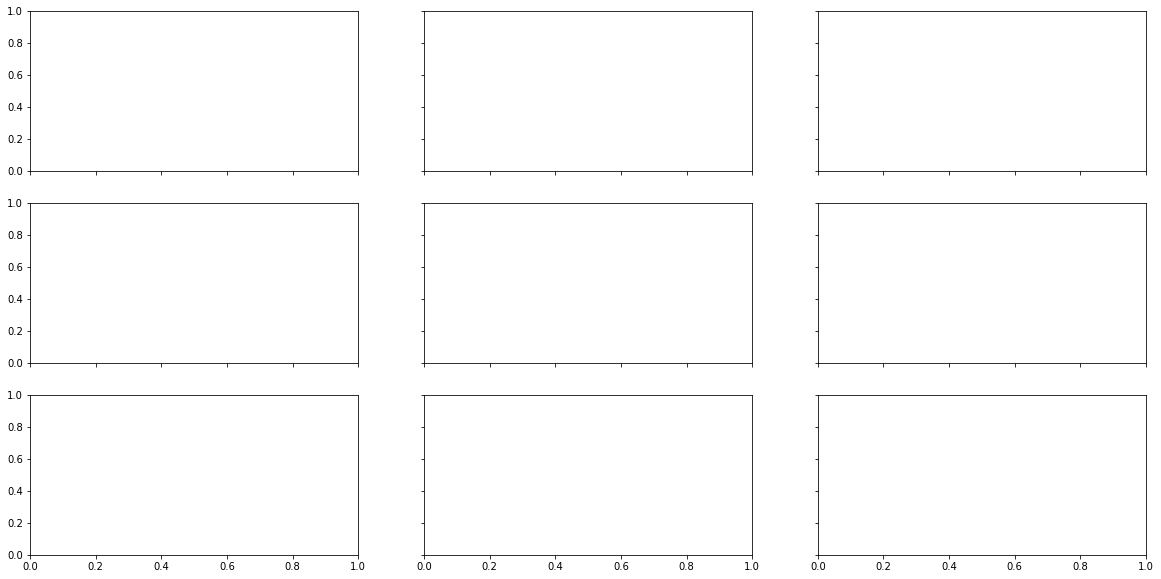

In [8]:
# First, validate that exact_coverage_genome gives the same results as a manual simulation:

rndab = RnaDB()

fig, axs = plt.subplots(3, 3, figsize=(20, 10), sharex=True, sharey=True)
for i in range(3):
    for j in range(3):
        lp = np.log(np.random.rand() + 1)
        genome = np.random.choice(rnadb.complete_genomes, 1)[0]
        oor = rnadb[genome]["oor_position"].iloc[0] / rnadb[genome]["size"].iloc[0]

        rna_locations, rna_probs = _exact_coverage_curve_genome(genome, lp)
        x = np.linspace(0, 1)
        all_probs = _exact_coverage_curve(locations=x, oor=oor, log_ptr=lp)

        axs[i,j].plot(x, all_probs, label="Theory")
        axs[i,j].scatter(rna_locations, rna_probs, label="Simulated for genome")
        axs[i,j].vlines((oor + .5) % 1, ymin=np.min(all_probs), ymax=np.max(all_probs), label="OOR", color="red")
        axs[i,j].set_title(f"Genome: {genome}   PTR: {np.exp(lp):.2f}   OOR: {oor:.2f}")

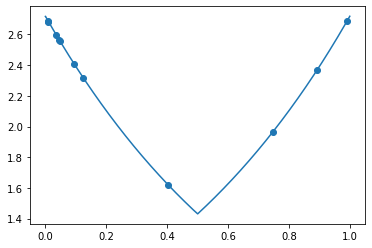

In [25]:
# Sampling curve is self-consistent:

(r_l, r_c), (w_l, w_c) = _coverage_16s_and_wgs(rnadb.complete_genomes[0], log_ptr=np.log(1.9), db=rnadb)

plt.plot(w_l, w_c)
plt.scatter(r_l, r_c)

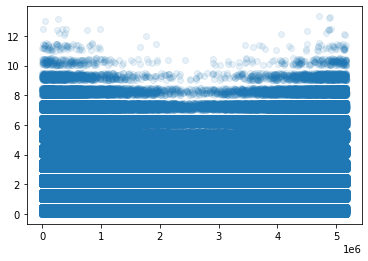

In [ ]:
starts, hits = _sample_from_system(rna_positions=r_l, wgs_probs=w_c)
plt.scatter(
    range(len(starts)), starts+0.5*np.random.rand(len(starts)), alpha=0.1
)

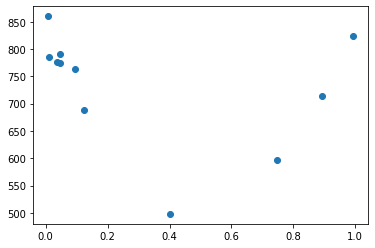

In [ ]:
# If anything, the RNA sums seem better behaved than WGS (due to summation):

plt.scatter(r_l, hits)

## Now let's really test our system:

In [12]:
new_results = pd.DataFrame(columns=["genome", "ptr", "ptr_hat", "err"])

for genome in tqdm(rnadb.complete_genomes):
    genome_object, md5s, g2s = rnadb.generate_genome_objects([genome])
    seqs = genome_object[0]["seqs"]

    for i in range(5):
        lp = np.log(np.random.rand() + 1)
        rna_locations, rna_probs = _exact_coverage_curve_genome(genome, log_ptr=lp, db=rnadb)
        coverages = rna_probs @ g2s

        solver = TorchSolver(
            genomes=genome_object,
            coverages=coverages
        )
        a, b, l = solver.train(verbose=False, epochs=2)
        new_results = new_results.append({
            "genome": genome,
            "ptr": np.exp(lp),
            "ptr_hat": np.exp(b[0]),
            "err": np.exp(lp) - np.exp(b[0])
        }, ignore_index=True)

new_results.to_csv("../data/scores/10x_simulation_with_fixed_simulation.csv", index=False)

  0%|          | 2/547 [00:06<27:25,  3.02s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Count')

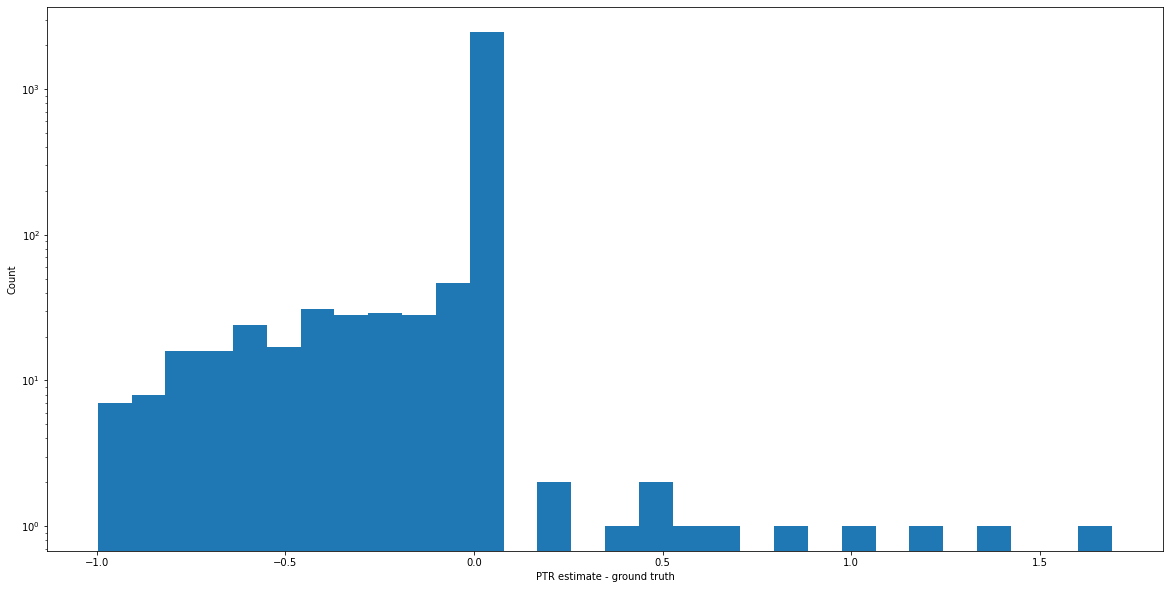

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.hist(-new_results["err"], bins=30)
plt.yscale("log")
plt.xlabel("PTR estimate - ground truth")
plt.ylabel("Count")

## Test sample generation capabilities

In [ ]:
def test_with_simulation(genome, log_ptr, db=rnadb):
    sample = simulate_sample(genome=genome, log_ptr=log_ptr, db=rnadb)
    solver = TorchSolver(
        genomes=db.generate_genome_objects([genome])[0],
        coverages=sample
    )
    a, b, l = solver.train(verbose=False, epochs=2)
    return a, b, l

In [ ]:
# I factored this out to large_simulation_experiment.py

# results = pd.DataFrame(
#     columns=["scale", "genome_id", "trial", "ptr", "est_ptr", "err", "loss"]
# )

# for scale in [.1, 1, 10, 100]:
#     print(f"Starting scale: {scale}")
#     # for genome in tqdm(rnadb.complete_genomes):
#     for genome in tqdm(rnadb.complete_genomes[:30]):
#         for trial in range(10):
#             try:
#                 lp = np.log(np.random.rand() + 1)
#                 a, b, l = test_with_simulation(genome, lp, rnadb)
#                 results = results.append({
#                     "scale": scale,
#                     "genome_id": genome,
#                     "trial": trial,
#                     "ptr": np.exp(lp),
#                     "est_ptr": np.exp(b[0]),
#                     "err": np.exp(lp) - np.exp(b[0]),
#                     "loss": l[-1]
#                 }, ignore_index=True)
#             except Exception as e:
#                 print(f"Problem with {scale} {genome} {trial}: {str(e)}")

Starting scale: 0.1


 20%|██        | 6/30 [00:48<03:19,  8.33s/it]

In [17]:
results = pd.read_csv("../data/scores/large_simulation_experiment_newsim.csv")

Text(0, 0.5, 'Normalized Count')

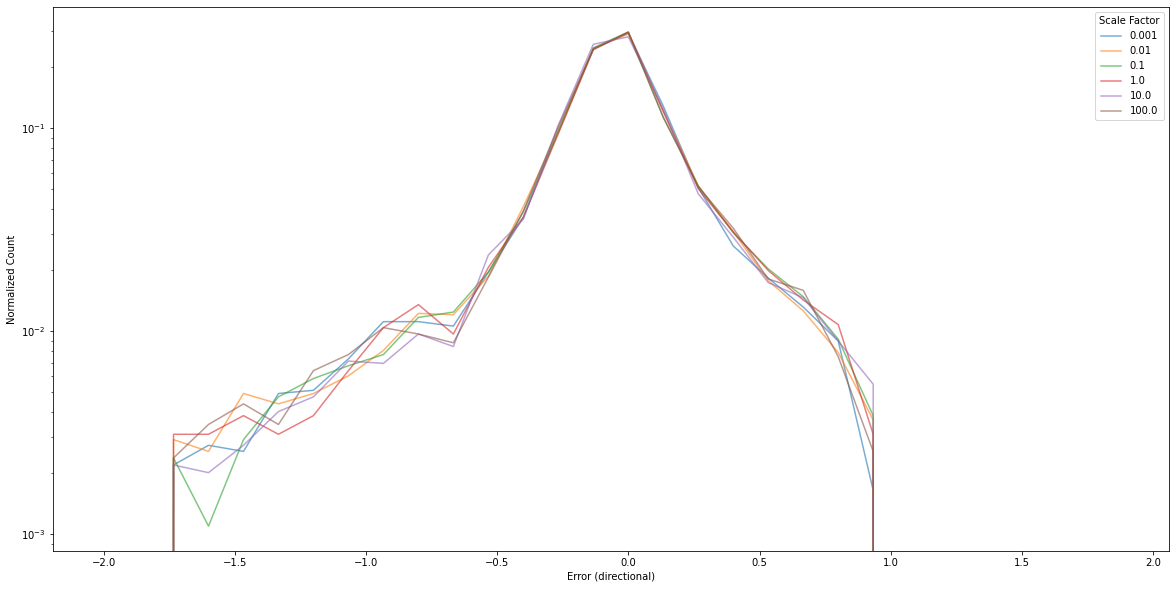

In [23]:
fig = plt.figure(figsize=(20,10 ))
for scale in results["scale"].unique():
    hist = np.histogram(results[results["scale"] == scale]["err"], bins=30, range=(-2, 2))
    plt.plot(hist[1][0:-1], hist[0] / np.sum(hist[0]), label=scale, alpha=0.6)

plt.legend(title="Scale Factor")
plt.yscale("log")
plt.xlabel("Error (directional)")
plt.ylabel("Normalized Count")


In [56]:
gen = "903510.3"
(r_l, _), (_, w_p) = _coverage_16s_and_wgs(gen, log_ptr=np.log(1.81), db=rnadb)
genome_object = rnadb.generate_genome_objects([gen])[0]
log_ptr = np.log(1.81)

scale_exps = np.arange(-4, 2, 0.5)
poisson_results = pd.DataFrame()

figure = plt.figure(figsize=(20,10))
for i in range(10):
    errs = []
    for scale_exp in scale_exps:
        sample = simulate_sample(genome=gen, log_ptr=log_ptr, db=rnadb, multiplier=10**scale_exp)
        solver = TorchSolver(
            genomes=rnadb.generate_genome_objects(gen)[0],
            coverages=sample
        )
        try:
            a, b, l = solver.train(verbose=False, epochs=2)
            b = b[0]
            err = np.exp(b) - np.exp(log_ptr)
            poisson_results = poisson_results.append({
                "trial": i,
                "scale_exp": scale_exp,
                "n_reads": np.sum(sample),
                "err": err
            }, ignore_index=True)
        except Exception as e:
            print(f"{scale_exp}\tProblem with trial: {str(e)}")

-4.0	Problem with trial: 'NoneType' object has no attribute 'detach'
-4.0	Problem with trial: 'NoneType' object has no attribute 'detach'
-4.0	Problem with trial: 'NoneType' object has no attribute 'detach'


<AxesSubplot:title={'center':'err'}, xlabel='scale_exp'>

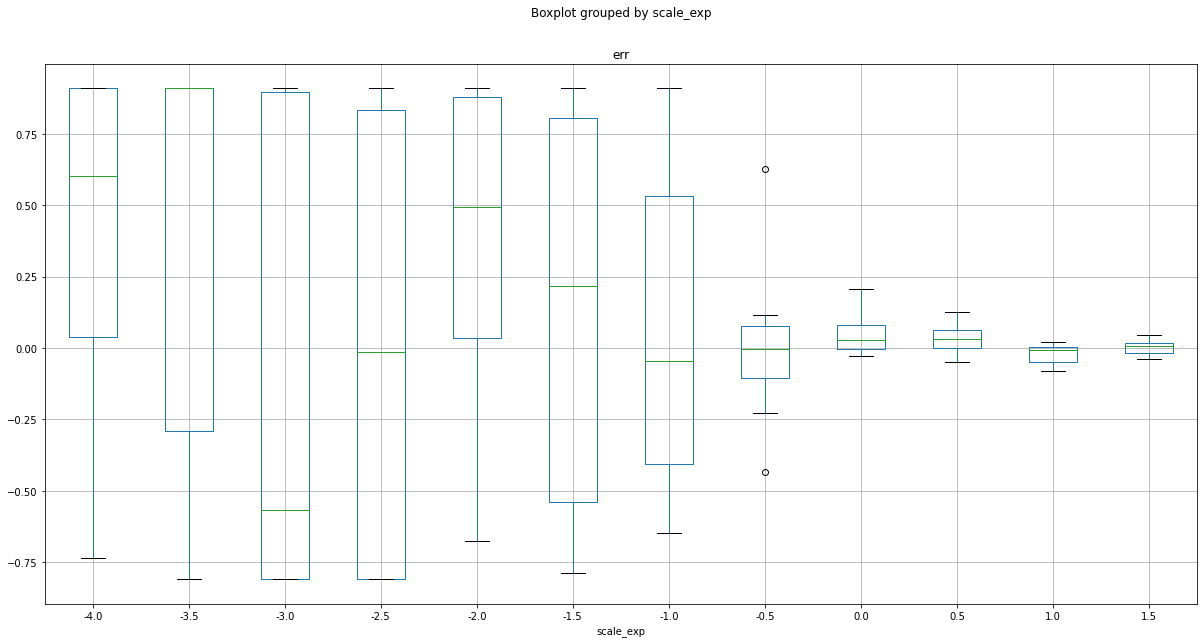

In [ ]:
poisson_results.boxplot(column="err", by="scale_exp", figsize=(20,10))

In [ ]:
fig = plt.figure(figsize(20, 10))

plt.plot()